<a href="https://colab.research.google.com/github/ssarker21/Introduction-to-Machine-Learning/blob/main/Homework_7Problem_1(b).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Active Device: cpu


100%|██████████| 170M/170M [00:01<00:00, 95.2MB/s]



Epoch-wise Evaluation Metrics
-------------------------------------------------------
Epoch |    Test Loss |  Test Accuracy
-------------------------------------------------------
    1 |       1.1586 |         0.5834
    2 |       0.8415 |         0.6990
    3 |       0.8070 |         0.7247
    4 |       0.7522 |         0.7420
    5 |       0.6556 |         0.7794
    6 |       0.6617 |         0.7754
    7 |       0.6613 |         0.7890
    8 |       0.6632 |         0.7985
    9 |       0.6442 |         0.8053
   10 |       0.6588 |         0.8035
   11 |       0.8034 |         0.7904
   12 |       0.8018 |         0.7883
   13 |       0.7907 |         0.8050
   14 |       0.8151 |         0.8053
   15 |       0.9669 |         0.7871
   16 |       0.9451 |         0.7979
   17 |       0.9235 |         0.7970
   18 |       0.9327 |         0.8009
   19 |       1.0664 |         0.7976
   20 |       0.9504 |         0.8038
   21 |       0.9832 |         0.8021
   22 |       0.9811 

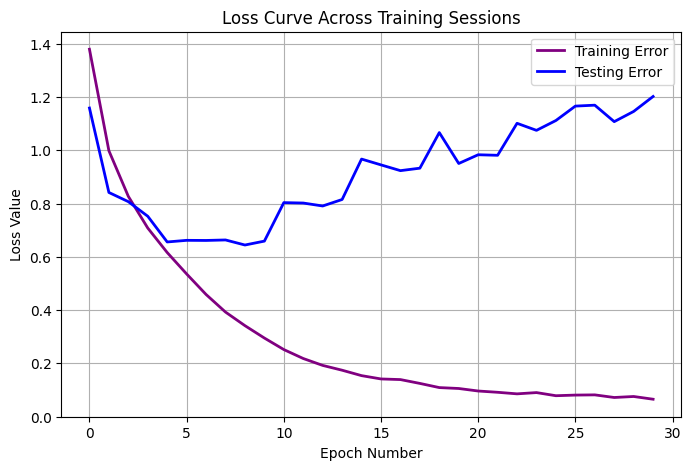

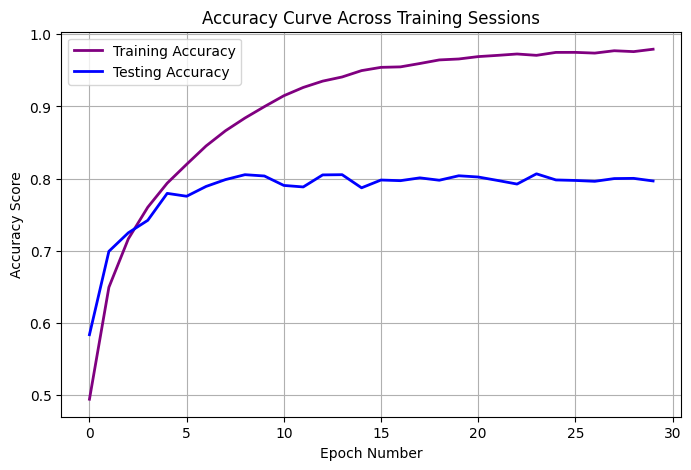

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import time

# Device Setup
compute_dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Active Device:", compute_dev)

# Transformations & Data Loaders
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4907, 0.4877, 0.4765],
        std=[0.2003, 0.1950, 0.2310]
    )
])

train_data = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=img_transform
)
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=64, shuffle=True, num_workers=0
)

test_data = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=img_transform
)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=64, shuffle=False, num_workers=0
)

label_names = train_data.classes

# ----------------------------------------------------
# CNN model – extended with one more conv+ReLU+pool
# ----------------------------------------------------
class CIFAR_Model(nn.Module):
    def __init__(self):
        super(CIFAR_Model, self).__init__()

        # 32x32 -> 16x16
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # 16x16 -> 8x8
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # 8x8 -> 4x4
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # NEW: 4x4 -> 2x2
        self.block4 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # After 4 pools: 32x32 -> 16 -> 8 -> 4 -> 2, channels = 256
        # Flatten size = 256 * 2 * 2 = 1024
        self.fc_layer1 = nn.Linear(256 * 2 * 2, 256)
        self.fc_layer2 = nn.Linear(256, 10)
        self.drop = nn.Dropout(0.5)

    def forward(self, z):
        z = self.block1(z)
        z = self.block2(z)
        z = self.block3(z)
        z = self.block4(z)          # pass through new conv+pool block
        z = z.view(z.size(0), -1)   # flatten -> (batch_size, 1024)
        z = F.relu(self.fc_layer1(z))
        z = self.drop(z)
        z = self.fc_layer2(z)
        return z

cnn = CIFAR_Model().to(compute_dev)

# Loss & Optimizer
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(cnn.parameters(), lr=0.0015)

# Training Phase
tr_losses = []
ts_losses = []
tr_accs = []
ts_accs = []

epochs = 30
time_start = time.time()

for ep in range(epochs):

    # ----- Training -----
    cnn.train()
    ep_loss = 0.0
    tr_correct = 0
    tr_total = 0

    for images, labels in train_loader:
        images = images.to(compute_dev)
        labels = labels.to(compute_dev)

        preds = cnn(images)
        err = loss_fn(preds, labels)

        opt.zero_grad()
        err.backward()
        opt.step()

        ep_loss += err.item()
        _, guess = torch.max(preds, 1)
        tr_total += labels.size(0)
        tr_correct += (guess == labels).sum().item()

    tr_losses.append(ep_loss / len(train_loader))
    tr_accs.append(tr_correct / tr_total)

    # ----- Testing -----
    cnn.eval()
    ts_loss = 0.0
    ts_correct = 0
    ts_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(compute_dev)
            labels = labels.to(compute_dev)

            out = cnn(images)
            loss_v = loss_fn(out, labels)

            ts_loss += loss_v.item()
            _, guess = torch.max(out, 1)
            ts_total += labels.size(0)
            ts_correct += (guess == labels).sum().item()

    ts_losses.append(ts_loss / len(test_loader))
    ts_accs.append(ts_correct / ts_total)

time_end = time.time()
total_runtime = time_end - time_start

# Validation Data Table
print("\nEpoch-wise Evaluation Metrics")
print("-" * 55)
print(f"{'Epoch':>5} | {'Test Loss':>12} | {'Test Accuracy':>14}")
print("-" * 55)
for i, (ls, ac) in enumerate(zip(ts_losses, ts_accs), start=1):
    print(f"{i:5d} | {ls:12.4f} | {ac:14.4f}")
print("-" * 55)

# Runtime Summary Table
print("\nRuntime Summary")
print("-" * 48)
print(f"{'Parameter':<25} | {'Value':>18}")
print("-" * 48)
print(f"{'Total Epochs':<25} | {epochs:18d}")
print(f"{'Total Time (seconds)':<25} | {total_runtime:18.2f}")
print(f"{'Time per Epoch (sec)':<25} | {total_runtime/epochs:18.2f}")
h = int(total_runtime // 3600)
m = int((total_runtime % 3600) // 60)
s = total_runtime % 60
print(f"{'Formatted Time (h:m:s)':<25} | {h:02d}:{m:02d}:{s:04.1f}")
print("-" * 48)

# Architecture Table
def show_architecture(model):
    print("\nModel Structure & Parameter Count")
    print("-" * 65)
    print(f"{'Layer Name':<40} | {'Params':>12}")
    print("-" * 65)

    total = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            n = param.numel()
            total += n
            print(f"{name:<40} | {n:12d}")

    print("-" * 65)
    print(f"{'Total Trainable Params':<40} | {total:12d}")
    print("-" * 65)

show_architecture(cnn)

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(tr_losses, label="Training Error", color="purple", linewidth=2)
plt.plot(ts_losses, label="Testing Error", color="blue", linewidth=2)
plt.xlabel("Epoch Number")
plt.ylabel("Loss Value")
plt.title("Loss Curve Across Training Sessions")
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(tr_accs, label="Training Accuracy", color="purple", linewidth=2)
plt.plot(ts_accs, label="Testing Accuracy", color="blue", linewidth=2)
plt.xlabel("Epoch Number")
plt.ylabel("Accuracy Score")
plt.title("Accuracy Curve Across Training Sessions")
plt.legend()
plt.grid(True)
plt.show()
